<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/CBPE_0916.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CBPE 실험

+ 이번 실험에서 가장 중요 Point는 아래 2가지
> 1. uncertainty(reference, inference, model) 측정에서 reference의 사이즈와, inference의 사이즈를 동일하게 유지.
> 2. 1번과 연동하여 sliding window 형식으로 live_set을 적용.
<pre>
초기 Input dataset
 +---------------------------------------+----------------+
 |              Trainset (100개)         | Testset (10개) |
 +---------------------------------------+----------------+
 이때 초기 Metric 측정 및 uncertainty의 inference는 아래와 같이 구성됨. (해당 Set으로 Noise 유도)
       +---------------------------------+----------------+
       |       Trainset(10:100) 90개     | Testset (10개) |  100개
       +---------------------------------+----------------+
첫번째 Liveset
               +-------------------------+----------------+----------------+
               |   Trainset 80개         | Testset (10개) |  Liveset(10개) | 100개
               +-------------------------+----------------+----------------+
두번째 Liveset
                      +------------------+----------------+--------------------------------+
                      |    Trainset 70개 | Testset (10개) |          Liveset(20개)         | 100개
                      +------------------+----------------+--------------------------------+
세번째 Liveset
Trainset 60개 + Testset 10개 + Liveset 30개 = 100개
</pre>
+ 이상과 같은 조건으로 Noise를 유도하고 실험 검증하면, 완벽하지는 않으나 비교적 활용 가능한 정도의 Threshold를 산출 할 수 있다.
+ Drift의 발생을 감지 못 할 경우도 있다.
+ Sigma 값은 0~1 사이로 낮게 적용. block sampling 적용. Noise Sample의 개수 = Trainset 의 개수
<pre>
    exp_model_param = {
        "exp_num":[400],#,5000,10000],
        "split_ratio": 1,
        "sigma":[0,1],
        "ramdom_sample_block":True,
        "metric":[accuracy, f1]
        }
</pre>

# 1 구글 드라이브 연결

In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# package install

In [2]:
!pip install nannyml
!pip install sdv==0.18.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.5/260.5 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 16.9 MB/s eta 0:00:00


# 2 함수 선언



In [109]:
#@title
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

#@title
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import os
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        s, p = stats.ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

## 준비

In [49]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

#4 실험

## Real-world data(Loan data)의 실험

### Data 준비

In [8]:
df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

(2260701, 151)


In [9]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted


(1345310, 151)
(1345310, 101)
(1345310, 56)
(1341026, 56)
(1341026, 53)
(1341026, 44)


,id,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,...,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag,loan_paid
0,68407277,3600.0,36 months,13.99,C,C4,MORTGAGE,55000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
1,68355089,24700.0,36 months,11.99,C,C1,MORTGAGE,65000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2,68341763,20000.0,60 months,10.78,B,B4,MORTGAGE,63000.0,Not Verified,Dec-2015,...,Joint App,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
4,68476807,10400.0,60 months,22.45,F,F1,MORTGAGE,104433.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
5,68426831,11950.0,36 months,13.44,C,C3,RENT,34000.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,89905081,18000.0,60 months,9.49,B,B2,OWN,130000.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2260690,88948836,29400.0,60 months,13.99,C,C3,MORTGAGE,180792.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2260691,89996426,32000.0,60 months,14.49,C,C4,MORTGAGE,157000.0,Source Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,0
2260692,90006534,16000.0,60 months,12.79,C,C1,RENT,150000.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,3.0,0.0,N,Cash,N,1


In [10]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64
(1341026, 41)
Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
(1341026, 86)
(1341026, 83)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341026 entries, 0 to 1341025
Data columns (total 83 columns):
 #   Column                      Non-Null Count    Dtype  

In [11]:

X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df_accepted.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [12]:

COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3',
       'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'Source Verified', 'Verified', 'Joint App', 'w', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT', 'DirectPay', 'Y'],
      dtype

In [13]:
X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

recoveries              0.375177
last_fico_range_high    0.095586
last_pymnt_amnt         0.086188
total_rec_late_fee      0.035108
int_rate                0.021824
                          ...   
B4                      0.000000
G4                      0.000000
G5                      0.000000
Source Verified         0.000000
total_acc               0.000000
Name: MI Scores, Length: 81, dtype: float64


### Loan Data 실험

In [14]:

# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

['recoveries',
 'last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate']

#### 실험 #1 Top 1~5, 4개의 feature 적용

In [15]:
top_columns = list(mi_scores[1:6].index)
top_columns

['last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate',
 'term']

In [16]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16, 14, 2, 1]

In [17]:

# 사용할 5개의 feature만 추림... ['last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate', 'term']
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)
X2 = X2[top_columns]

In [18]:
# 1/10 로 사이즈 줄이기...
seed_everything()
s = np.sort(np.random.choice(X2.shape[0],int(X2.shape[0]/10),replace= False))
#print(s.shape)
X3 = X2.iloc[s,:]
Y3 = Y2[s]

In [19]:
X3

,last_fico_range_high,last_pymnt_amnt,total_rec_late_fee,int_rate,term
8,754.0,5.81,0.0,8.94,36.0
19,739.0,24.70,0.0,13.92,36.0
41,769.0,845.25,0.0,12.53,36.0
43,719.0,182.76,0.0,13.92,36.0
52,809.0,284.71,0.0,8.59,36.0
...,...,...,...,...,...
1279596,529.0,248.30,0.0,7.35,36.0
1279609,729.0,26625.79,48.2,30.75,60.0
1279627,744.0,2216.56,0.0,10.42,36.0
1279639,579.0,628.61,0.0,13.59,36.0


#### NannyML CBPE
+ https://nannyml.readthedocs.io/en/stable/installing_nannyml.html

In [88]:
import nannyml as nml
from IPython.display import display

train_size = 2000
# train classifier

scaler = MinMaxScaler()
sx = scaler.fit_transform(X3[0:train_size].values)

model = RandomForestClassifier(max_depth=6).fit(sx, Y3[0:train_size])
reference_df = X3[0:train_size]
reference_df['loan_paid'] = Y3[0:train_size]
reference_df['y_pred'] = model.predict(X3[0:train_size])
reference_df['y_pred_proba'] = model.predict_proba(scaler.transform(X3[0:train_size].values))[:,1]

#train CBPE
estimator = nml.CBPE(
    y_pred_proba='y_pred_proba',
    y_pred='y_pred',
    y_true='loan_paid',
    chunk_number = 1,
    metrics=['accuracy'],
    problem_type='classification_binary',
)
estimator.fit(reference_df)

In [91]:
from tqdm import tqdm
from sklearn.metrics import f1_score,r2_score,precision_score,accuracy_score

test_size = 500

x_test = X3[test_size:train_size+test_size]
y_test = Y3[test_size:train_size+test_size].reshape(-1,1)

x_live = X3[test_size:]
y_live = Y3[test_size:].reshape(-1,1)

x_live_chunk = []
y_live_chunk = []
truncate_count = 0
for i in range(int(x_live.shape[0]/test_size)):
    xl = x_live[i*test_size:i*test_size+train_size]
    yl = y_live[i*test_size:i*test_size+train_size]
    if len(xl) ==  train_size:
        x_live_chunk.append(xl)
        y_live_chunk.append(yl)
    else:
        truncate_count = truncate_count + len(xl)

print(f'Truncate {truncate_count} rows from live_set {x_live.shape}')

real_accs = []
cbpe_accs = []

for x_chunk,y_chunk in zip(tqdm(x_live_chunk),y_live_chunk):
    y_pred = model.predict(scaler.transform(x_chunk))
    analysis_df = x_chunk
    analysis_df['y_pred_proba'] = model.predict_proba(scaler.transform(x_chunk))[:,1]
    analysis_df['y_pred'] =y_pred
    results = estimator.estimate(analysis_df)
    real_accs.append(accuracy_score(y_chunk,y_pred))
    cbpe_accs.append(results.filter(period='analysis').to_df()[[('accuracy','value')]].values[0,0])

Truncate 4404 rows from live_set (127468, 5)


100%|██████████| 251/251 [00:17<00:00, 14.42it/s]


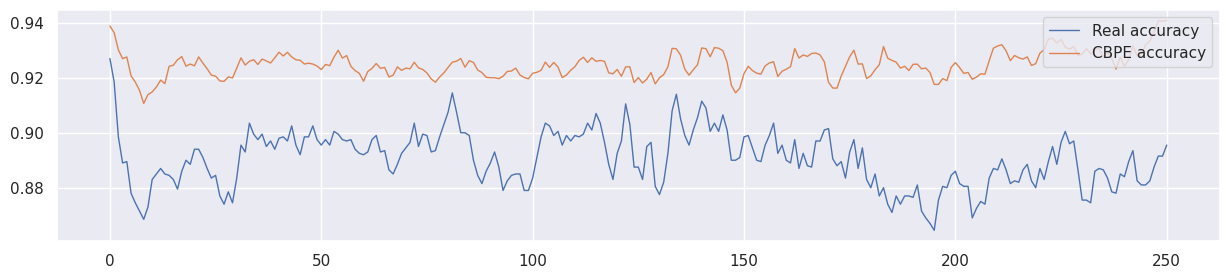

In [92]:
plt.figure(figsize=(15,3))
plt.plot(real_accs,linewidth=1,label='Real accuracy')
plt.plot(cbpe_accs,linewidth=1,label='CBPE accuracy')
plt.legend(loc='upper right')
plt.show()

# PPM

In [110]:
import copy
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def train_ppm(X,Y,n_epochs=1000):
    seed_everything()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #print(device)

    X = torch.tensor(X,dtype=torch.float32).to(device)
    Y = torch.tensor(Y,dtype=torch.float32).to(device)

    X, X_test, Y, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    in_dim = X.shape[1]
    # Define the model
    model = nn.Sequential(
        nn.Linear(in_dim, in_dim*8),
        nn.ReLU(),
        nn.Linear(in_dim*8, in_dim*12),
        nn.ReLU(),
        nn.Linear(in_dim*12, in_dim*8),
        nn.ReLU(),
        nn.Linear(in_dim*8, in_dim*4),
        nn.ReLU(),
        nn.Linear(in_dim*4, 1)
    ).to(device)

    # loss function and optimizer
    loss_fn = nn.MSELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    #n_epochs = 500   # number of epochs to run
    batch_size = 100  # size of each batch
    batch_start = torch.arange(0, len(X), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X[start:start+batch_size]
                y_batch = Y[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    print('')
    print("MSE: %.2f" % best_mse)
    print("RMSE: %.2f" % np.sqrt(best_mse))
    print("R2: %.2f" % r2_score(y_test.cpu().data.numpy(), y_pred.cpu().data.numpy()))
    plt.plot(history)
    plt.show()

    plt.plot(y_test.cpu().data.numpy(),label='real acc')
    plt.plot(y_pred.cpu().data.numpy(),label='pred acc')
    plt.legend()
    plt.show()


    return model


# tvae

In [98]:
import random
'''
Gen_X : X만 생성한다.
이때 Y는 학습한 classifer에 의해 생성한다.
단, 그대로 적용할 경우 acc 가 무조건 1이 되므로 confidence가 특정값 이하의 경우 (예:0.05) 0,1 을 임의 생성한다.
이는 생성한 X에 대해 classifier가 혼동스러울 경우,
classifier의 학습 경험에 의존 시키지 않고 임의로 class를 할당하여 acc를 1이 되지 않도록하는 것이다.
즉, 생성된 X의 drift가 클 수록 classifier는 혼동스러울 것이고 acc가 낮아지게 하는 효과를 만드는 것이다.
'''
def adjust_pred(y,param):
    if y > 0.5:
        if y < (0.5+param):
            return random.randint(0, 1)
        else:
            return 1
    else:
        if y > (0.5-param):
            return random.randint(0, 1)
        else:
            return 0

+ 두개의 Mode로 구분한다.
+ Gen_XY : X,Y를 모두 생성한다.
+ Gen_X : X만 생성한다. 이때 Y는 학습한 classifer에 의해 생성한다. 단, 그대로 적용할 경우 acc 가 무조건 1이 되므로 confidence가 특정값 이하의 경우 (예:0.05) 0,1 을 임의 생성한다. 이는 생성한 X에 대해 classifier가 혼동스러울 경우, classifier의 학습 경험에 의존 시키지 않고 임의로 class를 할당하여 acc를 1이 되지 않도록하는 것이다. 즉, 생성된 X의 drift가 클 수록 classifier는 혼동스러울 것이고 acc가 낮아지게 하는 효과를 만드는 것이다.

In [111]:
from sdv.tabular import TVAE
tvae_model = TVAE()

mode = 'Gen_XY'
r_param = 0.1  # 이 변수는
sample_count = 500

if mode == 'Gen_XY':
    ref_df = X3[train_size:train_size+test_size]
    ref_df['Y'] = Y3[train_size:train_size+test_size]
    tvae_model.fit(ref_df)
elif mode == 'Gen_X':
    tvae_model.fit(X3[train_size:train_size+test_size])

In [115]:

drifts = []
accs = []
print('Sampling synthetic data...')
for i in tqdm(range(sample_count)):

    sample_size = random.randint(0, test_size)
    if mode == 'Gen_XY':
        gen_df = tvae_model.sample(sample_size)
        gen_x = gen_df.values[:,0:5]
        gen_y = gen_df.values[:,5]
    elif mode == 'Gen_X':
        gen_x = tvae_model.sample(sample_size).values
        gen_y = [ adjust_pred(p,r_param) for p in model.predict_proba(scaler.transform(gen_x))[:,1]]

    drift = __ks_drift(X3[0:train_size].values,gen_x)
    f1 = accuracy_score(gen_y,model.predict(scaler.transform(gen_x)))

    drifts.append(drift[:,0])
    accs.append(f1)

drifts = np.asarray(drifts)
accs = np.asarray(accs)

print('Learning PPM...')
ppm = train_ppm(drifts,accs)

Sampling synthetic data...


 23%|██▎       | 117/500 [00:08<00:28, 13.47it/s]


IndexError: ignored

# PPM 적용 Test

In [113]:
real_accs = []
cbpe_accs = []
ppm_accs = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for x_chunk,y_chunk in zip(tqdm(x_live_chunk),y_live_chunk):
    #print(x_chunk.iloc[:,0:4])
    y_pred = model.predict(scaler.transform(x_chunk.iloc[:,0:5].values))
    analysis_df = x_chunk
    analysis_df['y_pred_proba'] = model.predict_proba(scaler.transform(x_chunk.iloc[:,0:5].values))[:,1]
    analysis_df['y_pred'] =y_pred
    results = estimator.estimate(analysis_df)
    real_accs.append(accuracy_score(y_chunk,y_pred))
    cbpe_accs.append(results.filter(period='analysis').to_df()[[('accuracy','value')]].values[0,0])
    drift = __ks_drift(X3[0:train_size].values,x_chunk.iloc[:,0:5].values)
    ppm_accs.append(ppm(torch.tensor(drift[:,0],dtype=torch.float32).to(device)).cpu().data.numpy())

100%|██████████| 251/251 [00:18<00:00, 13.32it/s]


adjust_value: [0.21197194]


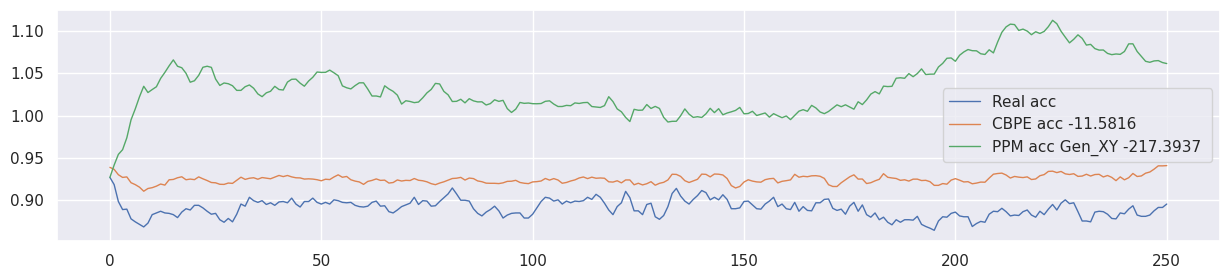

In [114]:
av = (real_accs[0] - ppm_accs[0])
print('adjust_value:',av)

cbpe_r2 = r2_score(real_accs,cbpe_accs)
ppm_r2 = r2_score(real_accs,ppm_accs+av)
plt.figure(figsize=(15,3))
plt.plot(real_accs,linewidth=1,label='Real acc')
plt.plot(cbpe_accs,linewidth=1,label=f'CBPE acc {cbpe_r2:.4f}')
plt.plot(ppm_accs+av,linewidth=1,label=f'PPM acc {mode} {ppm_r2:.4f} ')
plt.legend()
plt.show()

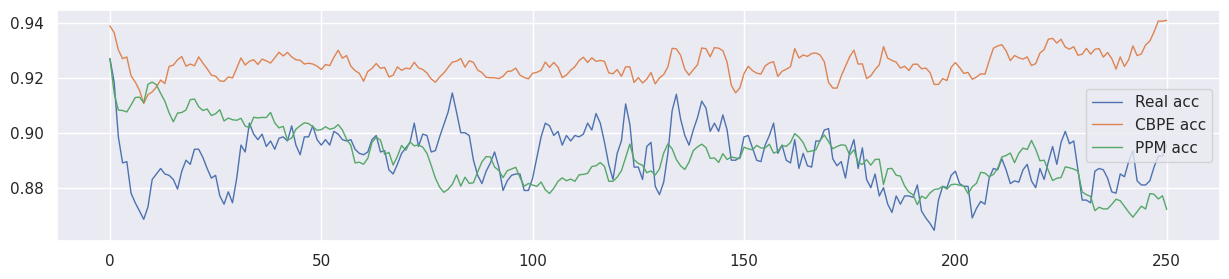

In [107]:
av = (real_accs[0] - ppm_accs[0])

plt.figure(figsize=(15,3))
plt.plot(real_accs,linewidth=1,label='Real acc')
plt.plot(cbpe_accs,linewidth=1,label='CBPE acc')
plt.plot(ppm_accs+av,linewidth=1,label='PPM acc')
plt.legend()
plt.show()